In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.stats import binned_statistic
import h5py
import gc
from sklearn.metrics import confusion_matrix

In [2]:
snapshot = 99
cvoxels = 1024  # child voxels
pvoxels = 32    # number of parent voxels
sim_boxsize = 205 # Mpc/h

sim_data = 'dark_matter_only'
data_dir = '/cosma7/data/dp004/dc-beck3/Dark2Light/data/%s/' % sim_data
sim_label = 'full_physics'
label_dir = '/cosma7/data/dp004/dc-beck3/Dark2Light/data/%s/' % sim_label

train_data_file = data_dir + '%s_s%d_v%d_dm_train.h5' % (sim_data, snapshot, cvoxels)
train_label_file = label_dir + '%s_s%d_v%d_dm_train.h5' % (sim_label, snapshot, cvoxels)

valid_data_file = data_dir + '%s_s%d_v%d_dm_valid.h5' % (sim_data, snapshot, cvoxels)
valid_label_file = label_dir + '%s_s%d_v%d_dm_valid.h5' % (sim_label, snapshot, cvoxels)

test_data_file = data_dir + '%s_s%d_v%d_dm_test.h5' % (sim_data, snapshot, cvoxels)
test_label_file = label_dir + '%s_s%d_v%d_dm_test.h5' % (sim_label, snapshot, cvoxels)

In [3]:
print(
    "If the simulation-box is devided into %d parent-voxels, " % (pvoxels) + \
    "the network would see a box with an edge-length of %.2f Mpc/h at a time" % (sim_boxsize/pvoxels))

If the simulation-box is devided into 32 parent-voxels, the network would see a box with an edge-length of 6.41 Mpc/h at a time


In [4]:
# load train data

def load_data(pvoxels):
    content = np.zeros((len(pvoxels.keys()), 2))
    ii = 0
    for k, v in pvoxels.items():                                                   
        content[ii, 0] = np.count_nonzero(v)
        content[ii, 1] = np.sum(v)
        ii += 1
    return content

pvoxels = h5py.File(train_data_file, "r")
print(pvoxels["parent_x0_y0_z0"].shape)
train_data_content = load_data(pvoxels)
pvoxels = h5py.File(train_label_file, "r")
train_label_content = load_data(pvoxels)
train = {
    "data" : train_data_content,
    "label" : train_label_content,
}

pvoxels = h5py.File(valid_data_file, "r")
valid_data_content = load_data(pvoxels)
pvoxels = h5py.File(valid_label_file, "r")
valid_label_content = load_data(pvoxels)
valid = {
    "data" : valid_data_content,
    "label" : valid_label_content,
}

pvoxels = h5py.File(test_data_file, "r")
test_data_content = load_data(pvoxels)
pvoxels = h5py.File(test_label_file, "r")
test_label_content = load_data(pvoxels)
test = {
    "data" : test_data_content,
    "label" : test_label_content,
}

del pvoxels
gc.collect()

(32, 32, 32)


7

In [5]:
print('train: ', np.min(train["data"][:,0]), np.max(train["data"][:,0]),
      np.min(train["label"][:,0]), np.max(train["label"][:,0]))
print('valid: ', np.min(valid["data"][:,0]), np.max(valid["data"][:,0]),
      np.min(valid["label"][:,0]), np.max(valid["label"][:,0]))
print('test: ', np.min(test["data"][:,0]), np.max(test["data"][:,0]),
      np.min(test["label"][:,0]), np.max(test["label"][:,0]))

print('train: ', np.min(train["data"][:,1]), np.max(train["data"][:,1]),
      np.min(train["label"][:,1]), np.max(train["label"][:,1]))
print('valid: ', np.min(valid["data"][:,1]), np.max(valid["data"][:,1]),
      np.min(valid["label"][:,1]), np.max(valid["label"][:,1]))
print('test: ', np.min(test["data"][:,1]), np.max(test["data"][:,1]),
      np.min(test["label"][:,1]), np.max(test["label"][:,1]))

train:  16780.0 31897.0 17251.0 31893.0
valid:  15525.0 30570.0 15970.0 30740.0
test:  16726.0 30708.0 17220.0 30837.0
train:  25788.0 24168979.0 25780.0 24514698.0
valid:  21658.0 13270869.0 21703.0 13046235.0
test:  26537.0 15130734.0 26530.0 15159057.0


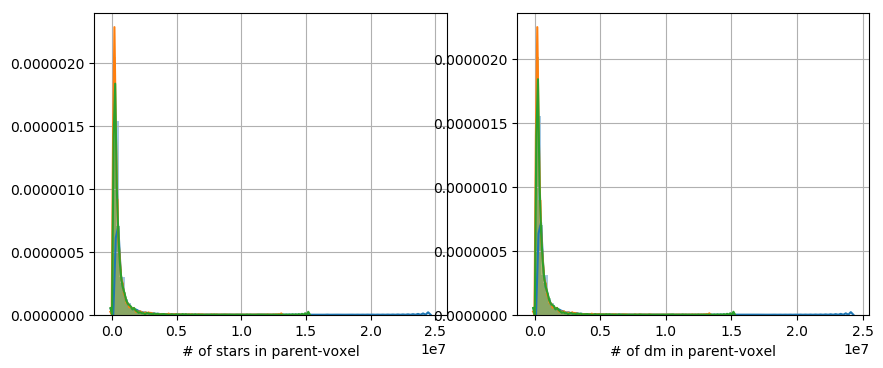

In [6]:
plt.figure(figsize=(10,4), dpi=100)
plt.subplot(121)
sns.distplot(train["label"][:,1])
sns.distplot(valid["label"][:,1])
sns.distplot(test["label"][:,1])
plt.xlabel("# of stars in parent-voxel")
plt.grid()

plt.subplot(122)
sns.distplot(train["data"][:,1])
sns.distplot(valid["data"][:,1])
sns.distplot(test["data"][:,1])
plt.xlabel("# of dm in parent-voxel")
plt.grid()

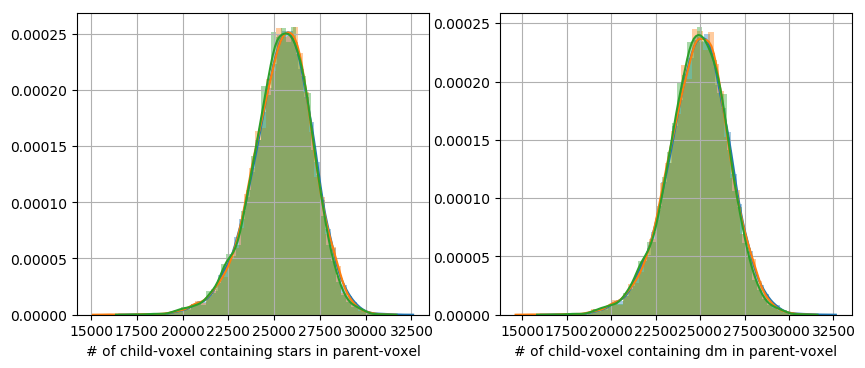

In [7]:
plt.figure(figsize=(10,4), dpi=100)
plt.subplot(121)
sns.distplot(train["label"][:,0])
sns.distplot(valid["label"][:,0])
sns.distplot(test["label"][:,0])
plt.xlabel("# of child-voxel containing stars in parent-voxel")
plt.grid()

plt.subplot(122)
sns.distplot(train["data"][:,0])
sns.distplot(valid["data"][:,0])
sns.distplot(test["data"][:,0])
plt.xlabel("# of child-voxel containing dm in parent-voxel")
plt.grid()

In [12]:
total_dm = np.sum(test["data"][:,1]) + np.sum(train["data"][:,1]) + np.sum(valid["data"][:,1])

In [13]:
print(f'{total_dm:.2E}')

1.56E+10


In [14]:
total_stars = np.sum(test["label"][:,1]) + np.sum(train["label"][:,1]) + np.sum(valid["label"][:,1])

In [15]:
print(f'{total_stars:.2E}')

1.56E+10


In [20]:
dm_only = test["data"][:,1]
stars = test["label"][:,1]

total_n_dm = np.sum(dm_only)
total_n_stars = np.sum(stars)

non_zero_dm_cells = len(np.where(dm_only.flatten() != 0. )[0])
percent_non_zero_dm_cells = non_zero_dm_cells/test["data"].shape[0]


non_zero_stars_cells = len(np.where(stars.flatten() != 0. )[0])
percent_non_zero_stars_cells = non_zero_stars_cells/test["label"].shape[0]


In [21]:
print('%.2f%% of the test cells have non-zero dark matter particles'%(percent_non_zero_dm_cells * 100))
print('%.2f%% of the test cells have non-zero stellar particles'%(percent_non_zero_stars_cells * 100))

100.00% of the test cells have non-zero dark matter particles
100.00% of the test cells have non-zero stellar particles


In [22]:
print('Total numbers:')
print('%d total dm particles'%total_n_dm)
print('%d total stellar particles'%total_n_stars)


Total numbers:
169146812 total dm particles
172837520 total stellar particles


In [24]:
print('Ranges:')
print('(%d, %d) dm particles/voxel'%(0,np.max(dm_only)))
print('(%d, %d) stellar particles/voxel'%(0,np.max(stars)))


Ranges:
(0, 47224) dm particles/voxel
(0, 47627) stellar particles/voxel


/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


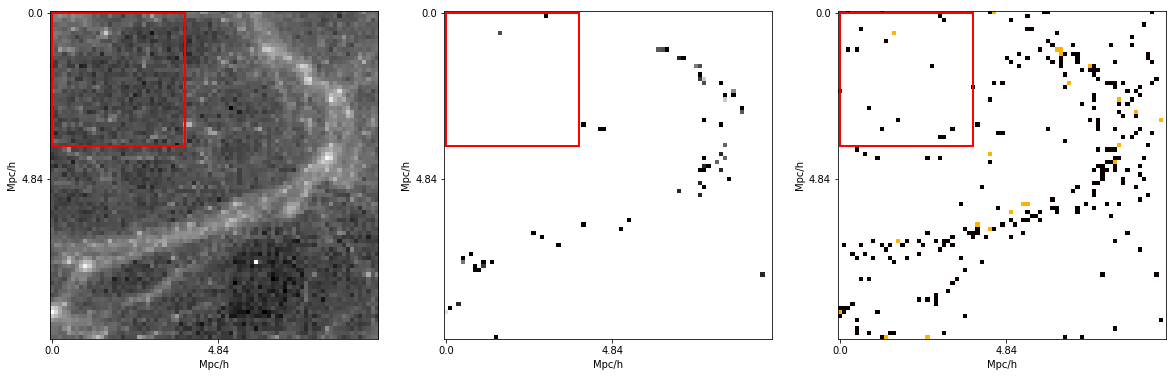

In [30]:
fig,axes = plt.subplots(1,3, figsize=(20,60))
boxes_to_show = [dm_box_projection, star_box_projection, sh_box_projection]
cmaps = ['gray', 'gray', 'hot']
for i, ax in enumerate(axes):
    
    #if(i==0):
    ax.imshow(np.log10(boxes_to_show[i]), cmap=cmaps[i])
    #else:
    #    ax.imshow((boxes_to_show[i]), cmap=cmaps[i])


    rect = patches.Rectangle((0,0),32,32,linewidth=2,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.set_xticks(xlabels_pos)
    ax.set_xticklabels(xlabels)
    ax.set_yticks(xlabels_pos)
    ax.set_yticklabels( xlabels)
    ax.set_xlabel('Mpc/h')
    ax.set_ylabel('Mpc/h')
    

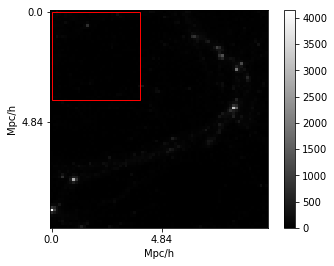

In [31]:
fig,ax = plt.subplots(1)

im = ax.imshow((boxes_to_show[0]), cmap='gray')

rect = patches.Rectangle((0,0),32,32,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xticks(xlabels_pos)
ax.set_xticklabels(xlabels)
ax.set_yticks(xlabels_pos)
ax.set_yticklabels( xlabels)
ax.set_xlabel('Mpc/h')
ax.set_ylabel('Mpc/h')
fig.colorbar(im)

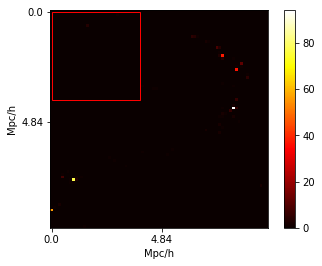

In [32]:
fig,ax = plt.subplots(1)

im = ax.imshow((boxes_to_show[1]), cmap='hot')

rect = patches.Rectangle((0,0),32,32,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xticks(xlabels_pos)
ax.set_xticklabels(xlabels)
ax.set_yticks(xlabels_pos)
ax.set_yticklabels( xlabels)
ax.set_xlabel('Mpc/h')
ax.set_ylabel('Mpc/h')
fig.colorbar(im)

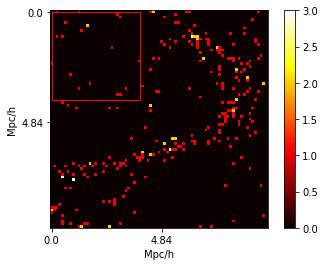

In [33]:
fig,ax = plt.subplots(1)

im = ax.imshow((boxes_to_show[-1]), cmap='hot')

rect = patches.Rectangle((0,0),32,32,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xticks(xlabels_pos)
ax.set_xticklabels(xlabels)
ax.set_yticks(xlabels_pos)
ax.set_yticklabels( xlabels)
ax.set_xlabel('Mpc/h')
ax.set_ylabel('Mpc/h')
fig.colorbar(im)

## TEST CONFUSION MATRIX FOR DIFFERENT CUTS

In [25]:
# Get rid of voxels with no dark matter
stars_true = stars > 0
print(stars_true)

[ True  True  True ...  True  True  True]


In [26]:
minimum_n_dm = 200

stars_pred = dm_only > minimum_n_dm
print(stars_pred)

[ True  True  True ...  True  True  True]


In [30]:
cm = confusion_matrix(stars_true, stars_pred)

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(ACC)
print(TPR)
print(PPV)


[1.]
[1.]
[1.]


/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
